In [10]:
"""
Created on Wed Apr 13 20:57:44 2022
@author: lfsto & mht 4/16/2022
"""


#----#----#----#----#----#----#----#----#----#----#----#----#
#----#
#----# Exectute this file, 
#----# Then run run_model() with parameters for 
#----#   the spatial resolution, the time steps, and frequency cutoff.
#----# Then run gif(), no parameters
#----#
#----# Note that gif() will save files to your computer! 
#----# GIF() WILL SAVE FILES TO YOUR COMPUTER!!!!!
#----# GIF() WILL SAVE HUNDREDS OF FILES TO YOUR COMPUTER!!!!!!
#----# It will save hundreds of files, 
#----# then delete them all (assuming it fully executes), then save 
#----# one final .gif
#----#
#----#----#----#----#----#----#----#----#----#----#----#----#


#%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import time
import os
import imageio

##### Solving the flow #####

def flow(u, x, odestep, h, steps):
	'''
	  u: vector field
	  x: n-by-2 array of initial conditions where n is the grid size
	  odestep: numerical method for solving ode
	  h: step size for numerical method
	  steps: total number of steps to take
	  The algorithm returns Points which is a steps-by-n-by-2 array.
	  Points[i,j,k] is the value of the kth coordinate of the jth point
	  at the ith time step. 
	'''
	Points = np.empty((steps,*x.shape))
	Points[0] = x
	for i in range(1,steps):
		x = odestep(u,x,h)
		x = x - np.floor(x)
		Points[i] = x
	return Points


##### ODE solvers #####

# Euler
def euler(u,x,h):
	return x + h * u(*x)

# Runge-Kutta 4
def rk4(u,x,h):
	k1 = u(*x)
	k2 = u(*(x + (h/2.0) * k1))
	k3 = u(*(x + (h/2.0) * k2))
	k4 = u(*(x + h * k3))
	return x + (h/6) * (k1 + 2.*(k2 + k3) + k4)

##### Initial data #####

def initial(x):
	initial_vals = np.ones_like(x)
	for i in np.ndindex(x.shape):
		if x[i] > 0.5:
			initial_vals[i] = 0.
	return initial_vals

# def sin(x):
#     z = 2*(x%1)-1
#     return sum([(-1)**(n//2) * np.pi**n * z**n / np.math.factorial(n) for n in range(1,20,2)])

# def cos(x):
#     z = 2*(x%1)-1
#     return sum([(-1)**(n//2+1) * np.pi**n * z**n / np.math.factorial(n) for n in range(0,20,2)])

def make_field(n,alpha = 2.25, sigma = 1.0, seed = 0):
    '''
    n: Number of Fourier modes used to generate the field
    alpha: power of Xi function, Default set to 2.25
    sigma: Scales the standard deviation (sigma)of the normally randomly distributed coefficents [0.1,...,2.0]
           Default set to 1.0
    seed: Seed of random number sequence used in the simmulation. Default set to 0.    
    '''
    from numpy import linalg as LA
    np.random.seed(seed)   
    total = np.array([np.full_like(x,0),np.full_like(x,0)])
    coeff = np.zeros((n,n,4))
    scale = sigma*np.ones(4)

    coeff[:,:,0] = scale[0]*np.random.normal(np.zeros((n,n)))
    coeff[:,:,1] = scale[1]*np.random.normal(np.zeros((n,n)))
    coeff[:,:,2] = scale[2]*np.random.normal(np.zeros((n,n)))
    coeff[:,:,3] = scale[3]*np.random.normal(np.zeros((n,n)))

    coeff[0] = 2*np.pi*coeff[0]/LA.norm(coeff[0], 'fro')
    coeff[1] = 2*np.pi*coeff[1]/LA.norm(coeff[1], 'fro')
    coeff[2] = 2*np.pi*coeff[2]/LA.norm(coeff[2], 'fro')
    coeff[3] = 2*np.pi*coeff[3]/LA.norm(coeff[3], 'fro')
    
    def velocity(x, y):
        total = np.array([np.full_like(x, 0),np.full_like(x, 0)])
        cos_x_vals = {}
        sin_x_vals = {}
        cos_y_vals = {}
        sin_y_vals = {}
        Xi = np.ones((n,n))
        
        for i in range(n):
            cos_x_vals[i] = np.cos(2*np.pi*i*x)
            sin_x_vals[i] = np.sin(2*np.pi*i*x)
            for j in range(n):
                Xi[i,j] = (1.0/(1+i*i+j*j))**(alpha/2.0)
                cos_y_vals[j] = np.cos(2*np.pi*j*y)
                sin_y_vals[j] = np.sin(2*np.pi*j*y)

        for i,j in zip(range(n),range(n)):
            size_opp =  Xi[i,j]*(coeff[i,j,0] * (sin_x_vals[i] * sin_y_vals[j] - cos_x_vals[i]*cos_y_vals[j])
                        + coeff[i,j,1] * (sin_x_vals[i] * cos_y_vals[j] + cos_x_vals[i]*sin_y_vals[j]))
            size_same=  Xi[i,j]*(coeff[i,j,2] * (sin_x_vals[i] * sin_y_vals[j] + cos_x_vals[i]*cos_y_vals[j])
                + coeff[i,j,3] * (sin_x_vals[i] * cos_y_vals[j] - cos_x_vals[i]*sin_y_vals[j]))
            total +=  [j*(size_same - size_opp),i*(size_same+size_opp)]

        return total

    return velocity

def run_model(grid_resolution, frequency_range, num_time_steps,alpha = 2.25, sigma = 1.0, seed = 32):
    '''
    Parameters:
    grid_resolution: Specifies the smoothness (high value) or corseness of the grid (low value).
    frequency_range: Number of Fourier modes used to generate the field
    num_time_steps: Number of time steps taken
    alpha: power of Xi function, Default set to 2.25
    sigma: Scales the standard deviation of the normally randomly distributed coefficents [0.1,...,2.0]
           Default set to 1.0
    seed: Seed of random number sequence used in the simmulation. Default set to 0. Good values to try 5, 10, 20     
    '''
    global u, points,grid,initial_vals,h,steps,n,freq
    n = grid_resolution
    freq = frequency_range
    grid = np.array(np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n)))
    initial_vals = initial(grid[0])
    h = 0.01
    steps = num_time_steps
    u = make_field(frequency_range,alpha,sigma,seed)
    points = flow(u, grid, rk4, h, steps)


### Animation ###
'''
fig, ax = plt.subplots(1, 1)
colors = np.where(initial_vals.flatten()==1,'yellow','black')
scatter = ax.scatter(points[0,0].flatten(), points[0, 1].flatten(), s=3, c=colors)
def update(i):
  scatter.set_offsets(points[i,0].flatten(),points[i,1].flatten())
  return scatter,
anim = FuncAnimation(fig, update, frames=steps, interval=10, repeat=True)
#anim.save('Simulation3.mp4', fps=30)
plt.show()
'''


def gif():    #(x_vals, y_vals):
    filenames = []
    save_as = f"REU_Data_{time.strftime('%Y-%m-%d-%H.%M.%S')}_sigma={sigma}.gif"
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True
    fig, ax = plt.subplots(1, 1)

    colors = np.where(initial_vals.flatten()==1,'pink','blue')
    scatter = ax.scatter(points[0,0].flatten(), points[0, 1].flatten(), s=3, c=colors)
    ax.set_title(f"resolution {n}, u frequencies up to {freq}, sigma = {sigma}")

    for i in range(steps):
        data = list(map(list,zip(points[i,0].flatten(),points[i,1].flatten())))

        scatter.set_offsets(data) #np.c_[data[::2], data[1::2]])
        filename = f"temp_image_{i}.png"
        filenames.append(filename)
        fig.savefig(filename)
        #fig.close()
    # build gif
    with imageio.get_writer(save_as, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [ ]:
run_model(grid_resolution=200, frequency_range=20, num_time_steps=800,alpha = 2.25, sigma = 5.0, seed = 10)
gif()

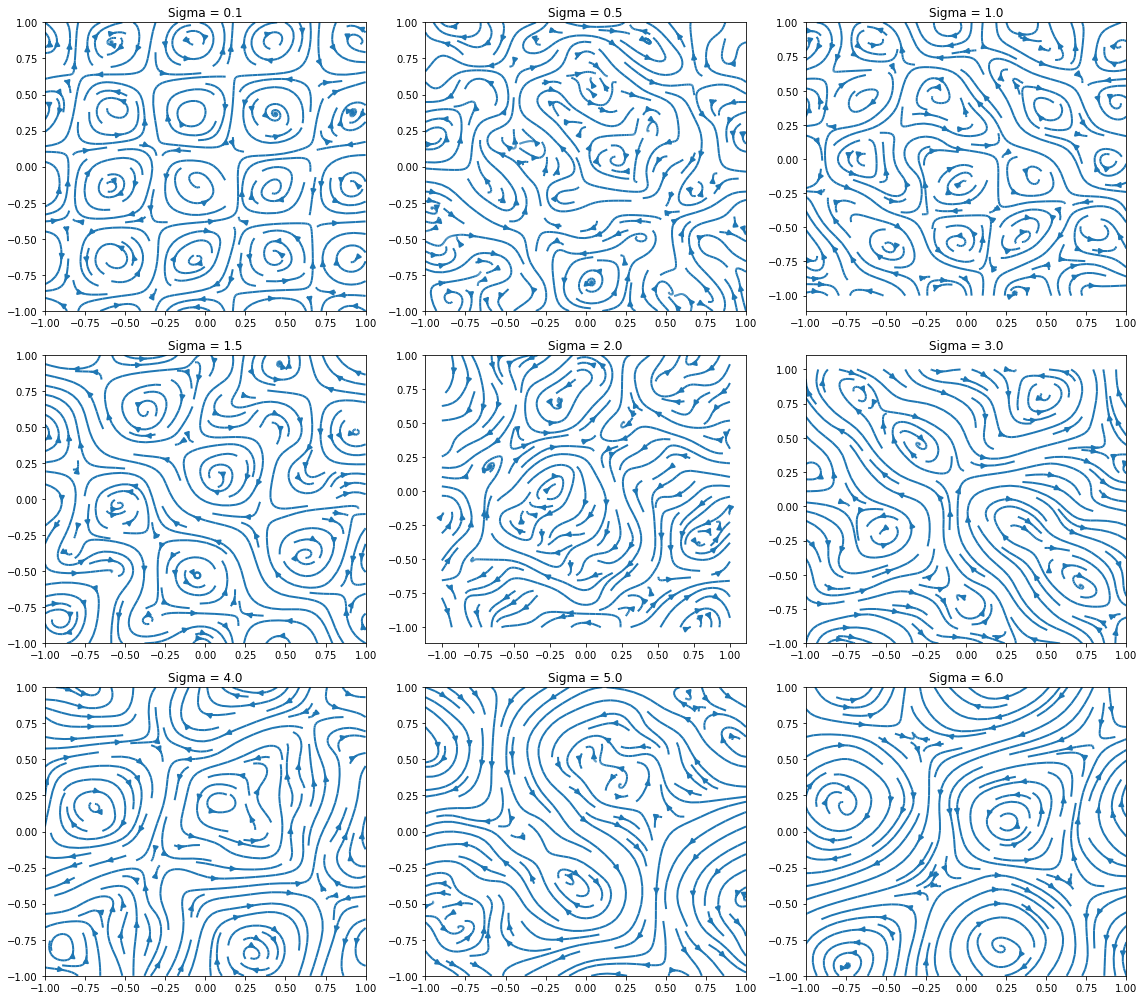

In [8]:
# Mixing Field Visualizer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

#set the width of the plot
w = 1.0
# Define the mesh grid
y,x = np.mgrid[-w:w:10j,-w:w:10j]

#Define the random vector field


#inputs for function make field

seed = 10
alpha = 2.25
n = 20
sigma = 1.0

# function body of make field

from numpy import linalg as LA

np.random.seed(seed)

def field(sigma):
    total = np.array([np.full_like(x,0),np.full_like(x,0)])
    coeff = np.zeros((n,n,4))
    scale = sigma*np.ones(4)

    coeff[:,:,0] = scale[0]*np.random.normal(np.zeros((n,n)))
    coeff[:,:,1] = scale[1]*np.random.normal(np.zeros((n,n)))
    coeff[:,:,2] = scale[2]*np.random.normal(np.zeros((n,n)))
    coeff[:,:,3] = scale[3]*np.random.normal(np.zeros((n,n)))

    coeff[0] = 2*np.pi*coeff[0]/LA.norm(coeff[0],'fro')
    coeff[1] = 2*np.pi*coeff[1]/LA.norm(coeff[1],'fro')
    coeff[2] = 2*np.pi*coeff[2]/LA.norm(coeff[2],'fro')
    coeff[3] = 2*np.pi*coeff[3]/LA.norm(coeff[3],'fro')

    Xi = np.ones((n,n))
    cos_x_vals = {}
    sin_x_vals = {}
    cos_y_vals = {}
    sin_y_vals = {}

    for i in range(n):
        cos_x_vals[i] = np.cos(2*np.pi*i*x)
        sin_x_vals[i] = np.sin(2*np.pi*i*x)
        for j in range(n):
            Xi[i,j] = (1.0/(1+i*i+j*j))**(alpha/2.0)
            cos_y_vals[j] = np.cos(2*np.pi*j*y)
            sin_y_vals[j] = np.sin(2*np.pi*j*y)
            
    for i,j in zip(range(n),range(n)):
        size_opp =  Xi[i,j]*(coeff[i,j,0] * (sin_x_vals[i] * sin_y_vals[j] - cos_x_vals[i]*cos_y_vals[j])
                    + coeff[i,j,1] * (sin_x_vals[i] * cos_y_vals[j] + cos_x_vals[i]*sin_y_vals[j]))
        size_same=  Xi[i,j]*(coeff[i,j,2] * (sin_x_vals[i] * sin_y_vals[j] + cos_x_vals[i]*cos_y_vals[j])
                    + coeff[i,j,3] * (sin_x_vals[i] * cos_y_vals[j] - cos_x_vals[i]*sin_y_vals[j]))
        total +=  [j*(size_same - size_opp),i*(size_same+size_opp)] 
    return total
        

plt.rcParams["figure.figsize"] = [12, 18]
plt.rcParams["figure.autolayout"] = True

F1, F2 = field(0.1)
F1_1, F2_1 = field(0.5)
F1_2, F2_2 = field(1.0)
F1_3, F2_3 = field(1.5)
F1_4, F2_4 = field(2.0)
F1_5, F2_5 = field(3.0)
F1_6, F2_6 = field(4.0)
F1_7, F2_7 = field(5.0)
F1_8, F2_8 = field(6.0)

# Plot the stream field
print(' ')
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

# Varying sigma
ax0 = fig.add_subplot(gs[0, 0])
strm = ax0.streamplot(x,y, F1, F2, linewidth=2)
ax0.set_title('Sigma = 0.1')

ax1 = fig.add_subplot(gs[0, 1])
strm = ax1.streamplot(x,y, F1_1, F2_1, linewidth=2)
ax1.set_title('Sigma = 0.5')

ax2 = fig.add_subplot(gs[0, 2])
strm = ax2.streamplot(x,y, F1_2, F2_2, linewidth=2)
ax2.set_title('Sigma = 1.0')

ax3 = fig.add_subplot(gs[1, 0])
strm = ax3.streamplot(x,y, F1_3, F2_3, linewidth=2)
ax3.set_title('Sigma = 1.5')

ax4 = fig.add_subplot(gs[1, 1])
strm = ax4.streamplot(x,y, F1_4, F2_4, linewidth=2)
ax4.set_title('Sigma = 2.0')

ax5 = fig.add_subplot(gs[1, 2])
strm = ax5.streamplot(x,y, F1_5, F2_5, linewidth=2)
ax5.set_title('Sigma = 3.0')

ax6 = fig.add_subplot(gs[2, 0])
strm = ax6.streamplot(x,y, F1_6, F2_6, linewidth=2)
ax6.set_title('Sigma = 4.0')

ax7 = fig.add_subplot(gs[2, 1])
strm = ax7.streamplot(x,y, F1_7, F2_7, linewidth=2)
ax7.set_title('Sigma = 5.0')

ax8 = fig.add_subplot(gs[2, 2])
strm = ax8.streamplot(x,y, F1_8, F2_8, linewidth=2)
ax8.set_title('Sigma = 6.0')

plt.tight_layout()
plt.show()